# Load Dicom data and convert to numpy
## Data file organization


* /naomi/DATA/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1
```
BraTS19_TCIA04_192_1_flair.nii.gz  
BraTS19_TCIA04_192_1_t1.nii.gz    
BraTS19_TCIA04_192_1_t2.nii.gz
BraTS19_TCIA04_192_1_seg.nii.gz    
BraTS19_TCIA04_192_1_t1ce.nii.gz
```

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema 
* Label 4: enhancing tumor

In [67]:
import paths
path_names = paths.set_names()

reduced_Data_HGG = path_names[4]
reduced_Data_LGG = path_names[5]
reduced_Val = path_names[1]

FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

NUMPY_DIR = path_names[6]
reducedVal_VALIDATION_DATA = path_names[1]
VALIDATION_NUMPY_DIR = path_names[7]


In [68]:
# 4 image types
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [69]:
import os, sys, glob
import SimpleITK as sitk
import sys
import os
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
import pandas as pd
import numpy as np
%matplotlib inline

In [70]:
## for outlineing tumors colouring tumors
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

## Visualization utils

In [71]:
from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
reload(vu)

<module 'visualization_utils' from '/Users/nathansimms/PycharmProjects/cmpt340-brain-tumor-detection2/visualization_utils.py'>

In [72]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);
    

## Data utilities

In [73]:
#read image and turn it into an array numbers. 
# Sikt allows for easy image manipulation
# http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

In [74]:
# change each MRI into 1 numpy coresponding label will also be 
# genrated

def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 155, 240, 240), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii.gz')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii.gz')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii.gz')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii.gz')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii.gz')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii.gz')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image

In [75]:
# genrate corespoding label from the segmented image
def read_lable_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((155, 240, 240), dtype=np.int)
    
    ## lable
    lable_img = os.path.join(dirpath, img_id+'_seg.nii.gz')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_sitk(lable_img).astype(int)

    return np_image

## Load data and Collect train data info

In [76]:
hgg_paths = []
for dirpath, dirnames, files in os.walk(reduced_Data_HGG):
    if ('BraTS19' in dirpath):
        hgg_paths.append(dirpath)

lgg_paths = []
for dirpath, dirnames, files in os.walk(reduced_Data_LGG):
    if ('BraTS19' in dirpath):
        lgg_paths.append(dirpath)
        
val_paths = []
for dirpath, dirnames, files in os.walk(reducedVal_VALIDATION_DATA):
    if ('BraTS19' in dirpath):
        val_paths.append(dirpath)

In [77]:
len(lgg_paths),len(hgg_paths),len(val_paths)

(28, 25, 30)

In [78]:
# find smallest bounding box for all non zero data. 
# Uses a 2D numpy array of a 3D image
def bbox2_3D(img):
    # finds the smallest box in 3D using r,c as x,y and  the corsponding z
    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

### View some data

In [79]:
img = reduced_Data_HGG + "/BraTS19_TCIA02_274_1"
np_img = read_image_into_numpy(img)

<Figure size 432x360 with 0 Axes>

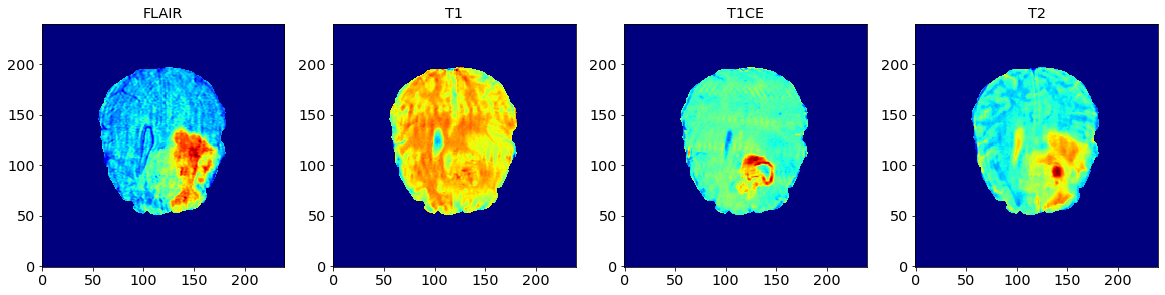

In [80]:
vu.show_n_images(np_img[:,100,:,:], titles=img_type)

In [84]:
img = reduced_Data_HGG + "/BraTS19_TCIA06_211_1"
np_lbl = read_lable_into_numpy(img)

<Figure size 432x360 with 0 Axes>

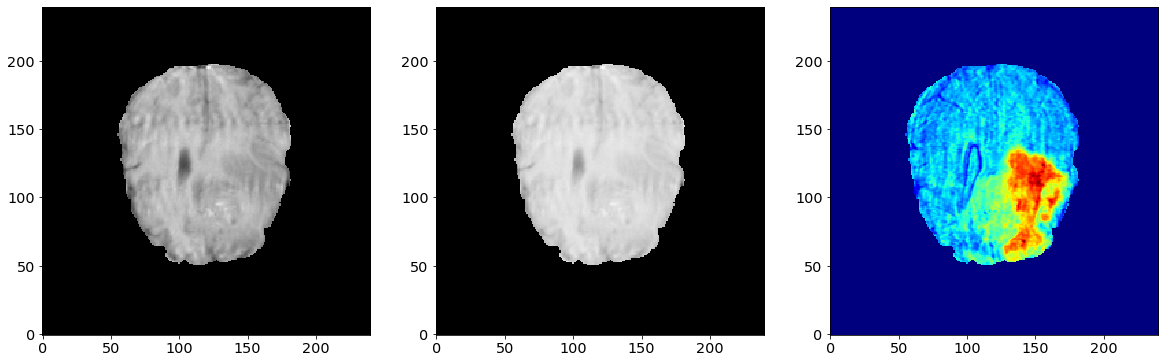

In [85]:
img1 = vu.show_lable_on_image4(np_img[1,100,:,:], np_lbl[100])
img2 = vu.show_lable_on_image(np_img[1,100,:,:], np_lbl[100])
vu.show_n_images([img1,img2,np_img[0,100]])

### Read all images collect data and save as numpy

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

Label 0: background
Label 1: necrotic and non-enhancing tumor
Label 2: edema
Label 4: enhancing tumor
In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:

(155, 240, 240, 4) For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

> Lables are 1, 2 and 4.
So we will save 4 as 3.
#### Dont forget to set it back to 4 prior submission to Brats.



In [86]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [87]:
# df for each image saving label values and bounding box
df = pd.DataFrame(columns=['Grade','id','lab0','lab1','lab2','lab3',
                           'rmin','rmax','cmin','cmax','zmin','zmax'])

In [88]:
# sum labels and create boudning box for images in HGG 
# this is reapllied for LGG as well overloading the args
def fill_df_from_path(df, paths = hgg_paths, grade='HGG'):

    for f in paths:
        np_img = read_image_into_numpy(f)
        np_lbl = read_lable_into_numpy(f)
        assert(np_lbl[np_lbl==3].sum()==0)
        np_lbl = np.where(np_lbl==4, 3, np_lbl)


        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:]

        nimg = os.path.join(NUMPY_DIR,  os.path.basename(f)+'.npy')
        np.save(nimg, new_img)
        nlbl = os.path.join(NUMPY_DIR,  os.path.basename(f)+'_lbl.npy')
        np.save(nlbl, np_lbl)

        lbls, repeats = np.unique(np_lbl, return_counts=True)
        lbl_counts=[0,0,0,0]
        for i in range(len(repeats)):
            lbl_counts[lbls[i]] = repeats[i]


        vals = [grade] + [os.path.basename(f)] + lbl_counts + bbox2_3D(np_lbl)

        df.loc[len(df)] = vals

    return df



In [89]:

df = fill_df_from_path(df, paths = lgg_paths, grade='LGG')
df = fill_df_from_path(df, paths = hgg_paths)

/Users/nathansimms/Documents/CMPT340/BratsData/2019Simple/MICCAI_BraTS_2019_Data_Training/reducedLGG/BraTS19_TCIA10_202_1/BraTS19_TCIA10_202_1_t2.nii.gz  not found aborting


TypeError: 'NoneType' object is not subscriptable

In [ ]:
df.shape

In [ ]:
# showng label imabalance, the rere types are lab1 and lab3 
# Lab1: non-enhancing tumor 
# Lab2: peritumoral edema
# Lab3: GD-enhancing tumor 


df[['lab' +str(i) for i in range(1,4)]].sum()

In [ ]:
lab1 = 2210984.0*100/(2210984.0+4086819.0+1314854.0)
lab2 = 4086819.0*100/(2210984.0+4086819.0+1314854.0)
lab3 = 6260157.0*100/(2210984.0+4086819.0+1314854.0)


print('lab1 %:', lab1)
print('lab2 %:', lab2)
print('lab3 %:', lab3)

In [ ]:
df[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution')

### Process validation data

In [ ]:
df_val = pd.DataFrame(columns=['id','lab0','lab1','lab2','lab3'])

In [ ]:
def fill_df_from_path(df=df_val, paths = val_paths):
    
    for f in paths:
        np_img = read_image_into_numpy(f)

        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:] 

        nimg = os.path.join(VALIDATION_NUMPY_DIR,  os.path.basename(f)+'.npy')
        np.save(nimg, new_img)
        
        vals = [os.path.basename(f)]+[0,0,0,0]
        df.loc[len(df)] = vals
        
    return df



In [ ]:
df_val = fill_df_from_path(df_val, paths = val_paths)

## Split data to train-test and save

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

In [ ]:
# used to help training in the unet file
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv',index=False)
df_val.to_csv('df_val.csv' ,index=False)


